In [1]:
targetFolderHBK = r"H:\Extracted_Features\HBK\HBK_14285Hz_highpass_all_features\features"
targetFolderMCC5 = r"H:\Extracted_Features\MCC5\MCC5_12800Hz_highpass_all_features_motor_vibration_x\features"
normalization_method = "z_score"

In [2]:
experiment_name = "highpass_data_analysis_binary"
project_name="highpass_data_analysis_binary",
run_name="highpass_data_analysis_binary"
domain="all"

domains_to_use = ['time', 'frequency', 'time-frequency']

In [3]:
binary_classification=True
plot_histograms_choice=False
include_augmentations=True

# Environment Setup & Imports

In [4]:
import os
import pandas as pd
import glob
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import pickle
import numpy as np
import mlflow
from pytorch_lightning.loggers import MLFlowLogger
from scipy import stats
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler
from sklearn.metrics import accuracy_score, balanced_accuracy_score, hamming_loss, hinge_loss, jaccard_score, log_loss, precision_score, recall_score, f1_score, make_scorer
from pathlib import Path
from pycaret.classification import * 
from torch import tensor
from torchmetrics.classification import BinaryAccuracy, MulticlassAccuracy
import optuna
import torch
from sklearn.model_selection import train_test_split
from pytorch_tabular import TabularModel
from pytorch_tabular.models import GANDALFConfig, CategoryEmbeddingModel,GatedAdditiveTreeEnsembleConfig, NodeConfig, FTTransformerConfig, TabNetModelConfig
from pytorch_tabular.config import (
    DataConfig,
    OptimizerConfig,
    ModelConfig,
    TrainerConfig,
    ExperimentConfig,
)
from collections import Counter
from data_loader import load_feature_data

## Helper Functions

In [5]:
def select_features_by_domain(domains: list, available_features: dict = None) -> list:
    """
    Selects a list of features based on the specified domains.

    Args:
        domains: A list of domain names (e.g., ['time', 'frequency']).
        available_features: A dictionary mapping domain names (keys) to 
                            lists of features (values). If None, uses a 
                            default dictionary.

    Returns:
        A flat list of all selected features.
    """
    # Define the complete feature set structure
    if available_features is None:
        available_features = {
            'time': ['rms', 'std', 'crest', 'energy', 'entropy'],
            'frequency': ['meanFreq', 'medianFreq', 'spectral_entropy', 'spectral_skewness'],
            # Assuming 'Time-Frequency' is referred to by a simpler domain name, 
            # or you can keep the full name
            'time-frequency': ['meanWavelet', 'varWavelet', 'entropyWavelet', 'entropySpectrogram']
        }

    selected_features = []
    
    # Iterate over the requested domains and extend the list
    for domain in domains:
        # Convert domain to lowercase for case-insensitive matching
        domain_key = domain.lower().replace('_', '-').strip()
        
        if domain_key in available_features:
            selected_features.extend(available_features[domain_key])
        else:
            print(f"Warning: Domain '{domain}' not recognized in available features.") # Optional warning

    # Return only unique features in case of overlap (though unlikely here)
    return list(set(selected_features))

In [6]:
features_to_include = select_features_by_domain(domains=domains_to_use)

In [7]:
def plotHistograms(dataframe, normalization):
    for col in dataframe.columns:
        if col == "Label":
            continue
        plt.figure(figsize=(8, 4))
        sns.histplot(data = dataframe, x=col, hue='Label', kde=True, multiple='layer', element='step', alpha=0.5)
        plt.title(f"Distribution of {col} with {normalization}")
        plt.show()

In [8]:
def normalizeDataframe(dataframe, normalization_method):
    """
    Normalizes the features of a dataframe using a specified method.

    Args:
        dataframe (pd.DataFrame): The input dataframe with a 'Label' column.
        normalization_method (str): The method to use ("min_max", "z_score", "robust_scaling").

    Returns:
        pd.DataFrame: The dataframe with scaled features.
    """
    # Separate features (X) and the target variable (y)
    y = dataframe['Label']
    X = dataframe.drop(columns=['Label'])

    # Select the scaler based on the chosen method
    if normalization_method == "min_max":
        scaler = MinMaxScaler()
    elif normalization_method == "z_score":
        scaler = StandardScaler()
    elif normalization_method == "robust_scaling":
        scaler = RobustScaler()
    else:
        # Raise an error for an invalid method name
        raise ValueError(f"Unknown normalization_method: '{normalization_method}'")

    # Fit the scaler to the data and transform it
    X_scaled = pd.DataFrame(
        scaler.fit_transform(X),
        columns=X.columns,
        index=X.index
    )

    # Rejoin the scaled features with the label column
    df_scaled = X_scaled.join(y)
    
    return df_scaled

In [9]:
def plotPredictionHistograms(df, normalization):
    # 1) mark correct vs incorrect
    df = df.copy()
    df['prediction_quality'] = np.where(
        df['Label'] == df['prediction_label'],
        'correct',
        'incorrect'
    )
    
    # 2) choose a palette (you can override these colors if you like)
    pal = dict(zip(
        ['correct','incorrect'],
        sns.color_palette(n_colors=2)
    ))
    
    skip = {'Label','prediction_label','prediction_score','prediction_quality'}
    for col in df.columns:
        if col in skip:
            continue
        
        fig, ax = plt.subplots(figsize=(8,4))
        sns.histplot(
            data=df, x=col, hue='prediction_quality',
            palette=pal,
            kde=True, multiple='layer', element='step',
            alpha=0.5,
            ax=ax
        )
        
        # 3) build a manual legend using the same palette
        handles = [
            mpatches.Patch(color=pal[k], label=k)
            for k in ['correct','incorrect']
        ]
        ax.legend(
            handles=handles,
            title='Prediction Quality'
        )
        
        ax.set_title(
            f"Distribution of {col}\n"
            f"(normalization = '{normalization}')"
        )
        ax.set_xlabel(col)
        ax.set_ylabel("Count")
        plt.tight_layout()
        plt.show()

In [10]:
def get_incorrect_predictions(df):
    return df[
        ((df['Label'] == 'damaged')   & (df['prediction_label'] == 'healthy'))
      | ((df['Label'] == 'healthy')  & (df['prediction_label'] == 'damaged'))
    ].copy()

In [11]:
def get_feature_importance_df(model, df):
    importance = model.feature_importances_
    n = len(importance)
    features = df.columns[:n]
    fi_df = pd.DataFrame({
        'Features': features,
        'importance': importance
    })
    return fi_df.sort_values(by='importance', ascending=False).reset_index(drop=True)

In [12]:
def get_svm_feature_importance_df(model, df):
    if not hasattr(model, 'coef_'):
        raise ValueError("This SVM model has no coefficients. Use a linear kernel.")
    
    importance = model.coef_.ravel()  # Flatten in case of binary classification
    n = len(importance)
    features = df.columns[:n]
    fi_df = pd.DataFrame({
        'Features': features,
        'importance': abs(importance)
    })
    return fi_df.sort_values(by='importance', ascending=False).reset_index(drop=True)


In [13]:
feature_counter = Counter()
def add_top_features(feature_df: pd.DataFrame, top_n: int):
    top_features = feature_df.nlargest(top_n, 'importance')['Features']
    feature_counter.update(top_features)
    
def plot_feature_importance():
    feature_freq = pd.DataFrame(feature_counter.items(), columns=['Feature', 'Count'])
    plt.figure(figsize=(10, 5))
    sns.barplot(data=feature_freq.sort_values(by='Count', ascending=False),
                x='Feature', y='Count')
    plt.xticks(rotation=45)
    plt.title('Feature Frequency Across Experiments')
    plt.tight_layout()
    plt.show()

In [14]:
def save_feature_counter(exp_name: str, folder: str = f"top_features_{experiment_name}"):
    os.makedirs(folder, exist_ok=True)
    filepath = os.path.join(folder, f"{exp_name}_features.csv")
    df = pd.DataFrame(feature_counter.items(), columns=['Feature', 'Count'])
    df.to_csv(filepath, index=False)

## Import Dataset

In [15]:
df_HBK = load_feature_data(
    features_path=targetFolderHBK,
    include_augmentations=include_augmentations,      # Only 'original' data
    include_speed_torque=False,       # Drop operating conditions
    binary_classification=binary_classification,       # 'healthy' vs 'damaged'
    features_to_include=features_to_include
)

Successfully loaded 966 files into a DataFrame with shape (1140403, 30)
Applied binary classification: 'healthy' vs 'damaged'.
Selected specific features: ['medianFreq', 'meanWavelet', 'spectral_entropy', 'spectral_skewness', 'entropySpectrogram', 'crest', 'entropy', 'varWavelet', 'meanFreq', 'std', 'rms', 'energy', 'entropyWavelet']
Dropped 'Speed' and 'Torque' columns.
Final DataFrame shape: (1140403, 14)


In [16]:
df_MCC5 = load_feature_data(
    features_path=targetFolderMCC5,
    include_augmentations=include_augmentations,      # Only 'original' data
    include_speed_torque=False,       # Drop operating conditions
    binary_classification=binary_classification,       # 'healthy' vs 'damaged'
    features_to_include=features_to_include
)

Successfully loaded 216 files into a DataFrame with shape (307368, 30)
Applied binary classification: 'healthy' vs 'damaged'.
Selected specific features: ['medianFreq', 'meanWavelet', 'spectral_entropy', 'spectral_skewness', 'entropySpectrogram', 'crest', 'entropy', 'varWavelet', 'meanFreq', 'std', 'rms', 'energy', 'entropyWavelet']
Dropped 'Speed' and 'Torque' columns.
Final DataFrame shape: (307368, 14)


In [17]:
combined_df = pd.concat([df_HBK, df_MCC5], ignore_index=True)

In [18]:
normalized_df = normalizeDataframe(combined_df, normalization_method)

In [19]:
features_df_training_normalized, features_df_testing_normalized = train_test_split(
    normalized_df, 
    test_size=0.2,    # e.g., 20% for testing
    random_state=42   # for reproducibility
)

# Histograms

## Histograms Training and Testing [NO-Normalization]

In [20]:
if (plot_histograms_choice):
    plotHistograms(combined_df, normalization_method)

## Histograms Training and Testing [Z-Score Normalization]

In [21]:
if (plot_histograms_choice):
    plotHistograms(normalized_df, normalization_method)

# Experiment Setup (ML)

## Setup Hyperparameters

In [22]:
experiment = setup(features_df_training_normalized, target='Label', log_experiment = True, experiment_name = experiment_name, use_gpu = True)

[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Info] Number of positive: 1, number of negative: 1
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 0
[LightGBM] [Info] Number of data points in the train set: 2, number of used features: 0
[LightGBM] [Info] Using GPU Device: Quadro P620, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 16 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Warning] GPU acceleration is disabled because no non-trivial dense features can be found
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split 

,Description,Value
0,Session id,5609
1,Target,Label
2,Target type,Binary
3,Target mapping,"damaged: 0, healthy: 1"
4,Original data shape,"(1158216, 14)"
5,Transformed data shape,"(1158216, 14)"
6,Transformed train set shape,"(810751, 14)"
7,Transformed test set shape,"(347465, 14)"
8,Numeric features,13
9,Preprocess,True


[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Info] Number of positive: 1, number of negative: 1
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 0
[LightGBM] [Info] Number of data points in the train set: 2, number of used features: 0
[LightGBM] [Info] Using GPU Device: Quadro P620, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 16 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Warning] GPU acceleration is disabled because no non-trivial dense features can be found
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split 

Traceback (most recent call last):
  File "C:\Users\ge35yay\.conda\envs\venv_masterarbeit_RMT\Lib\site-packages\mlflow\store\tracking\file_store.py", line 317, in search_experiments
    exp = self._get_experiment(exp_id, view_type)
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\ge35yay\.conda\envs\venv_masterarbeit_RMT\Lib\site-packages\mlflow\store\tracking\file_store.py", line 410, in _get_experiment
    meta = FileStore._read_yaml(experiment_dir, FileStore.META_DATA_FILE_NAME)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\ge35yay\.conda\envs\venv_masterarbeit_RMT\Lib\site-packages\mlflow\store\tracking\file_store.py", line 1341, in _read_yaml
    return _read_helper(root, file_name, attempts_remaining=retries)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\ge35yay\.conda\envs\venv_masterarbeit_RMT\Lib\site-packages\mlflow\store\tracking\file_store.py", line 1334, in _read_hel

In [23]:
experiment.y_test

128929     healthy
286442     healthy
20953      healthy
224629     healthy
1204767    damaged
            ...   
481570     damaged
1028580    damaged
222580     damaged
27674      healthy
758658     damaged
Name: Label, Length: 347465, dtype: category
Categories (2, object): ['damaged', 'healthy']

## Add aditional metrics

In [24]:
# Binary classification metrics
add_metric('balanced_acc', 'Balance Acc', balanced_accuracy_score, target='pred', greater_is_better=True)
add_metric('hamming_loss', 'Hamming Loss', hamming_loss, target='pred', greater_is_better=False)
add_metric('jaccard_score', 'Jaccard Score', jaccard_score, target='pred', greater_is_better=True)
add_metric('log_loss', 'Log Loss', log_loss, target='pred_proba', greater_is_better=False)

Name                                                          Log Loss
Display Name                                                  Log Loss
Score Function       <pycaret.internal.metrics.EncodedDecodedLabels...
Scorer               make_scorer(log_loss, greater_is_better=False,...
Target                                                      pred_proba
Args                                                                {}
Greater is Better                                                False
Multiclass                                                        True
Custom                                                            True
Name: log_loss, dtype: object

In [25]:
all_metrics = get_metrics()
all_metrics

,Name,Display Name,Score Function,Scorer,Target,Args,Greater is Better,Multiclass,Custom
ID,,,,,,,,,
acc,Accuracy,Accuracy,<function accuracy_score at 0x000001208B4532E0>,accuracy,pred,{},True,True,False
auc,AUC,AUC,<pycaret.internal.metrics.BinaryMulticlassScor...,"make_scorer(roc_auc_score, response_method=('d...",pred_proba,"{'average': 'weighted', 'multi_class': 'ovr'}",True,True,False
recall,Recall,Recall,<pycaret.internal.metrics.BinaryMulticlassScor...,"make_scorer(recall_score, response_method='pre...",pred,{'average': 'weighted'},True,True,False
precision,Precision,Prec.,<pycaret.internal.metrics.BinaryMulticlassScor...,"make_scorer(precision_score, response_method='...",pred,{'average': 'weighted'},True,True,False
f1,F1,F1,<pycaret.internal.metrics.BinaryMulticlassScor...,"make_scorer(f1_score, response_method='predict...",pred,{'average': 'weighted'},True,True,False
kappa,Kappa,Kappa,<function cohen_kappa_score at 0x000001208B453...,"make_scorer(cohen_kappa_score, response_method...",pred,{},True,True,False
mcc,MCC,MCC,<function matthews_corrcoef at 0x000001208B453...,"make_scorer(matthews_corrcoef, response_method...",pred,{},True,True,False
balanced_acc,Balance Acc,Balance Acc,<pycaret.internal.metrics.EncodedDecodedLabels...,"make_scorer(balanced_accuracy_score, response_...",pred,{},True,True,True
hamming_loss,Hamming Loss,Hamming Loss,<pycaret.internal.metrics.EncodedDecodedLabels...,"make_scorer(hamming_loss, greater_is_better=Fa...",pred,{},False,True,True


## Light Gradient Boosting Machine

In [26]:
bestParamsLIGHTGBM = {
    'bagging_fraction': 0.8455104741417432,
    'bagging_freq': 0,
    'boosting_type': 'gbdt',
    'class_weight': None,
    'colsample_bytree': 1.0,
    'device': 'gpu',
    'feature_fraction': 0.42947671039481,
    'importance_type': 'split',
    'learning_rate': 0.47910287588557177,
    'max_depth': -1,
    'min_child_samples': 41,
    'min_child_weight': 0.001,
    'min_split_gain': 0.23016472358397666,
    'n_estimators': 245,
    'n_jobs': -1,
    'num_leaves': 250,
    'objective': None,
    'random_state': 1768,
    'reg_alpha': 0.00039695268896179983,
    'reg_lambda': 3.6071600095045767e-06,
    'subsample': 1.0,
    'subsample_for_bin': 200000,
    'subsample_freq': 0
}


In [27]:
lightgbm = create_model('lightgbm', **bestParamsLIGHTGBM)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,Balance Acc,Hamming Loss,Jaccard Score,Log Loss
Fold,,,,,,,,,,,
0,0.9682,0.9934,0.9682,0.9681,0.9678,0.9103,0.9112,0.9451,0.0318,0.8708,0.0803
1,0.8386,0.6737,0.8386,0.8368,0.8171,0.4607,0.5033,0.6902,0.1614,0.3750,4.8997
2,0.9236,0.8951,0.9236,0.9225,0.9214,0.7778,0.7820,0.8688,0.0764,0.7041,1.7799
3,0.9683,0.9939,0.9683,0.9681,0.9679,0.9106,0.9113,0.9457,0.0317,0.8712,0.0776
4,0.8906,0.8405,0.8906,0.8874,0.8873,0.6814,0.6853,0.8225,0.1094,0.6010,3.0020
5,0.8856,0.7881,0.8856,0.8874,0.8762,0.6404,0.6644,0.7810,0.1144,0.5472,3.2014
6,0.8794,0.8469,0.8794,0.8780,0.8786,0.6631,0.6633,0.8274,0.1206,0.5895,3.4290
7,0.9285,0.9257,0.9285,0.9276,0.9279,0.7993,0.7998,0.8926,0.0715,0.7328,1.6550
8,0.8465,0.8763,0.8465,0.8721,0.8534,0.6211,0.6340,0.8471,0.1535,0.5679,4.6055


Traceback (most recent call last):
  File "C:\Users\ge35yay\.conda\envs\venv_masterarbeit_RMT\Lib\site-packages\mlflow\store\tracking\file_store.py", line 317, in search_experiments
    exp = self._get_experiment(exp_id, view_type)
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\ge35yay\.conda\envs\venv_masterarbeit_RMT\Lib\site-packages\mlflow\store\tracking\file_store.py", line 410, in _get_experiment
    meta = FileStore._read_yaml(experiment_dir, FileStore.META_DATA_FILE_NAME)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\ge35yay\.conda\envs\venv_masterarbeit_RMT\Lib\site-packages\mlflow\store\tracking\file_store.py", line 1341, in _read_yaml
    return _read_helper(root, file_name, attempts_remaining=retries)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\ge35yay\.conda\envs\venv_masterarbeit_RMT\Lib\site-packages\mlflow\store\tracking\file_store.py", line 1334, in _read_hel

[LightGBM] [Warning] feature_fraction is set=0.42947671039481, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.42947671039481
[LightGBM] [Warning] bagging_fraction is set=0.8455104741417432, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8455104741417432
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] feature_fraction is set=0.42947671039481, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.42947671039481
[LightGBM] [Warning] bagging_fraction is set=0.8455104741417432, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8455104741417432
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


2025/10/07 21:37:15 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.


In [28]:
evaluate_model(lightgbm)

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Pipeline Plot', 'pipelin…

In [29]:
lightgbm_top_features = get_feature_importance_df(lightgbm, features_df_training_normalized)
lightgbm_top_features

,Features,importance
0,meanFreq,7715
1,crest,7093
2,spectral_skewness,6771
3,medianFreq,6629
4,spectral_entropy,4866
5,entropy,4654
6,meanWavelet,4622
7,varWavelet,4012
8,entropySpectrogram,3989
9,entropyWavelet,3894


In [30]:
add_top_features(lightgbm_top_features, top_n=3)

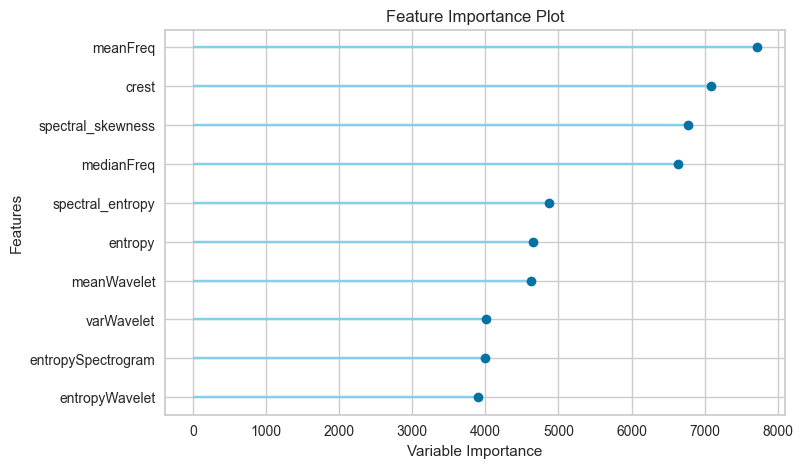

In [31]:
plot_model(lightgbm, plot='feature')

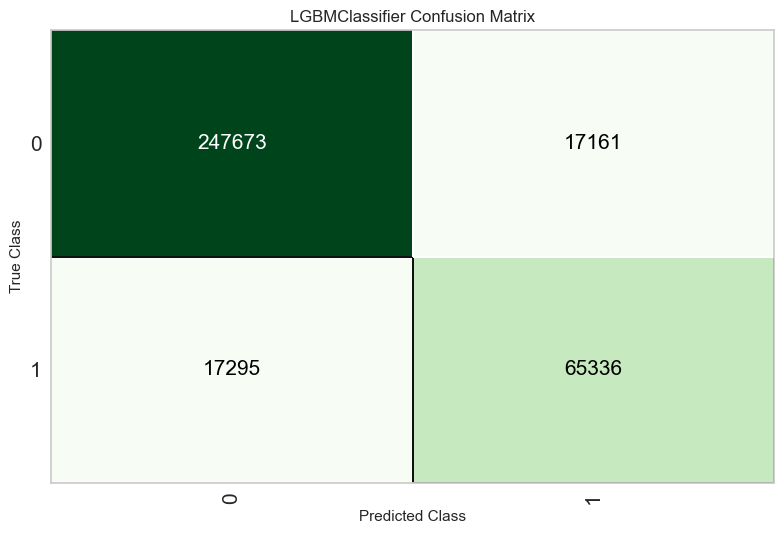

In [32]:
plot_model(lightgbm, plot='confusion_matrix')

In [33]:
predictions_lightgbm = predict_model(lightgbm, data = features_df_testing_normalized)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,Balance Acc,Hamming Loss,Jaccard Score,Log Loss
0,Light Gradient Boosting Machine,0.9007,0.8894,0.9007,0.9005,0.9006,0.7254,0.7255,0.8619,0.0993,0.6536,2.6383


[LightGBM] [Warning] feature_fraction is set=0.42947671039481, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.42947671039481
[LightGBM] [Warning] bagging_fraction is set=0.8455104741417432, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8455104741417432
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] feature_fraction is set=0.42947671039481, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.42947671039481
[LightGBM] [Warning] bagging_fraction is set=0.8455104741417432, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8455104741417432
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


In [34]:
predictions_lightgbm

,medianFreq,meanWavelet,spectral_entropy,spectral_skewness,entropySpectrogram,crest,entropy,varWavelet,meanFreq,std,rms,energy,entropyWavelet,Label,prediction_label,prediction_score
964828,1.615263,2.677861,2.654020,0.988907,1.370445,-0.978877,-1.841478,2.494686,1.932710,3.051327,3.051326,2.480551,-1.834050,damaged,damaged,1.0000
1096014,-0.389008,-0.123077,-0.325172,0.959696,-0.166290,0.114014,0.218184,-0.247068,-0.002114,-0.233821,-0.233822,-0.252569,0.198468,damaged,damaged,1.0000
1147751,-0.970482,-0.330750,-0.360333,-0.395950,-0.166373,-0.301183,0.216681,-0.253985,-1.113300,-0.331838,-0.331839,-0.266948,0.188616,healthy,damaged,0.8635
302654,-0.892717,-0.615573,-0.438652,0.613841,-0.166493,-0.344809,0.207165,-0.271789,-0.599916,-0.581299,-0.581300,-0.285984,0.173401,damaged,healthy,1.0000
130547,-0.113441,-0.607815,-0.436884,1.061889,-0.166492,-0.735765,0.207618,-0.271480,0.313728,-0.567295,-0.567296,-0.285583,0.173793,damaged,damaged,1.0000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1184245,-1.032531,-0.156330,-0.279653,-0.046630,-0.165328,-0.358432,0.220000,-0.219700,-1.233864,-0.130436,-0.130436,-0.233186,0.197727,healthy,damaged,0.9462
104625,-0.255917,-0.558421,-0.430890,-0.081021,-0.166489,-0.366866,0.208849,-0.270046,0.275680,-0.529464,-0.529464,-0.284103,0.175866,damaged,damaged,1.0000
1048208,-0.892940,0.211328,-0.133050,0.884975,-0.163903,-0.443914,0.215066,-0.183654,-0.242787,0.085434,0.085434,-0.178754,0.215196,damaged,damaged,1.0000
257315,0.043168,-0.690673,-0.442508,-2.131683,-0.166493,-0.632053,0.206021,-0.272473,0.829784,-0.637591,-0.637592,-0.286793,0.171861,healthy,healthy,1.0000


In [35]:
get_incorrect_predictions(predictions_lightgbm)

,medianFreq,meanWavelet,spectral_entropy,spectral_skewness,entropySpectrogram,crest,entropy,varWavelet,meanFreq,std,rms,energy,entropyWavelet,Label,prediction_label,prediction_score
1147751,-0.970482,-0.330750,-0.360333,-0.395950,-0.166373,-0.301183,0.216681,-0.253985,-1.113300,-0.331838,-0.331839,-0.266948,0.188616,healthy,damaged,0.8635
302654,-0.892717,-0.615573,-0.438652,0.613841,-0.166493,-0.344809,0.207165,-0.271789,-0.599916,-0.581299,-0.581300,-0.285984,0.173401,damaged,healthy,1.0000
1366489,1.077241,-0.234152,-0.273429,0.806683,-0.165966,-0.433774,0.220257,-0.233789,1.166599,-0.183261,-0.183262,-0.243631,0.195320,damaged,healthy,0.6616
553381,-1.479405,-0.649226,-0.441319,0.993163,-0.166493,2.169790,0.206410,-0.272281,-1.364569,-0.609234,-0.609232,-0.286546,0.172406,healthy,damaged,1.0000
123186,-0.894855,-0.592034,-0.435996,0.814243,-0.166492,-0.579219,0.207839,-0.271254,-0.736674,-0.561197,-0.561198,-0.285383,0.174256,damaged,healthy,1.0000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
591616,0.925350,-0.354958,-0.365713,1.267115,-0.166109,-1.006575,0.219099,-0.246998,0.977365,-0.291186,-0.291187,-0.261457,0.188307,damaged,healthy,1.0000
1168460,-1.065907,-0.440726,-0.386021,0.018872,-0.166299,-0.046978,0.214402,-0.257176,-1.589562,-0.373010,-0.373011,-0.271826,0.182755,healthy,damaged,0.6824
47218,-1.229747,-0.647127,-0.440510,0.702700,-0.166493,-0.140824,0.206595,-0.272165,-0.147231,-0.602293,-0.602293,-0.286435,0.172593,healthy,damaged,1.0000
1266612,-1.023018,-0.451665,-0.401517,-0.410486,-0.166433,1.562907,0.211953,-0.263143,-1.107517,-0.421080,-0.421080,-0.276654,0.181088,damaged,healthy,1.0000


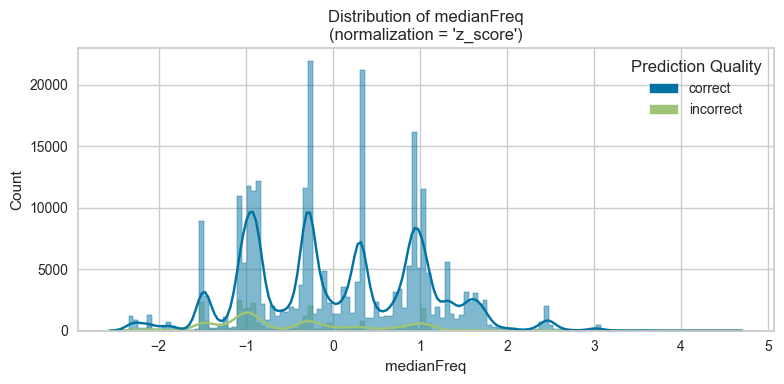

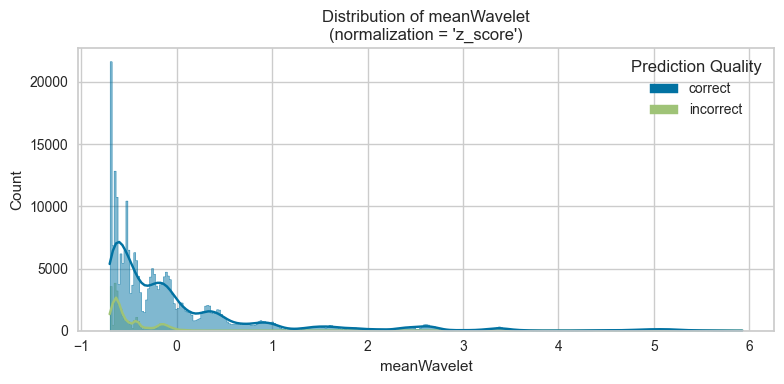

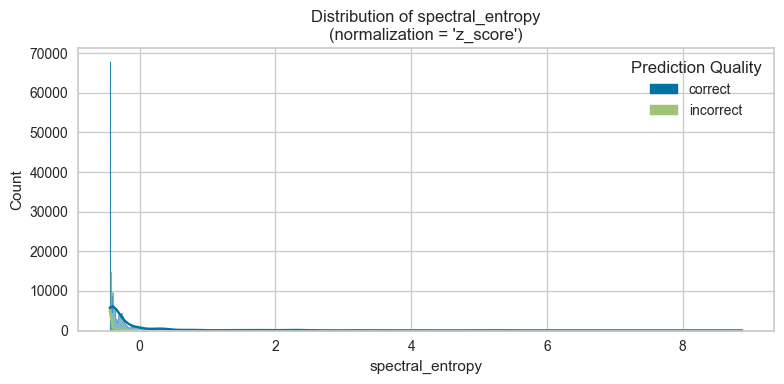

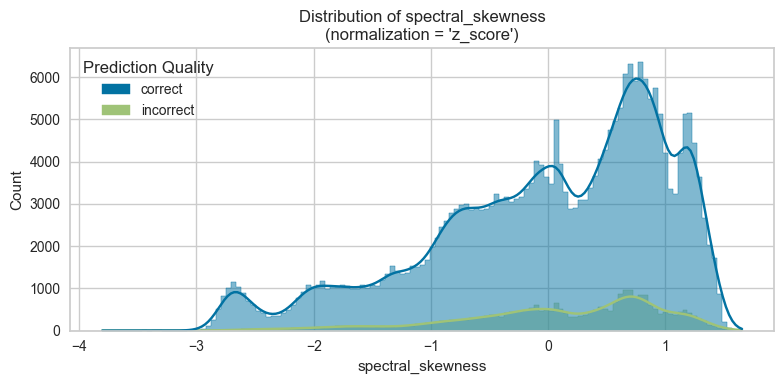

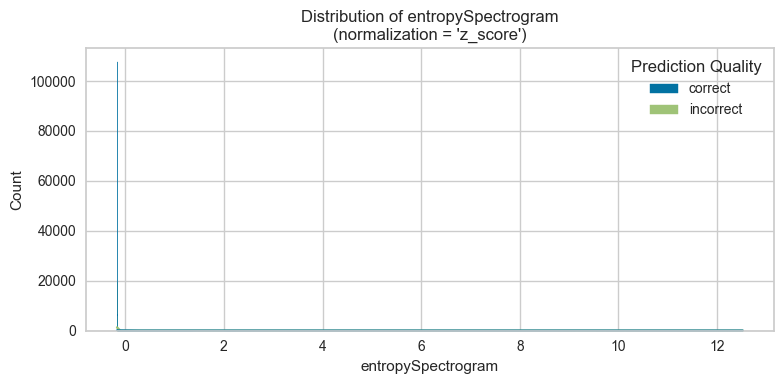

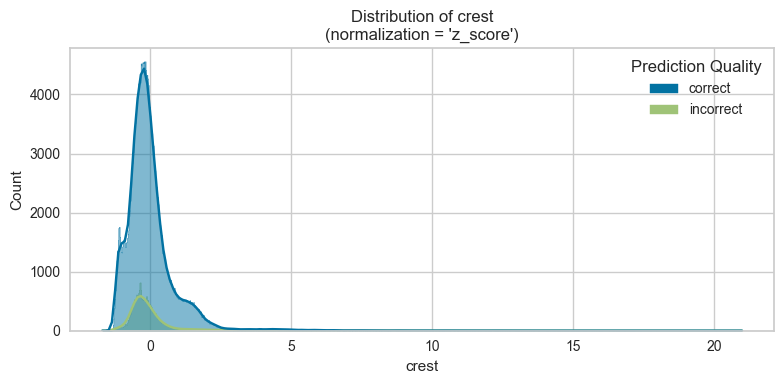

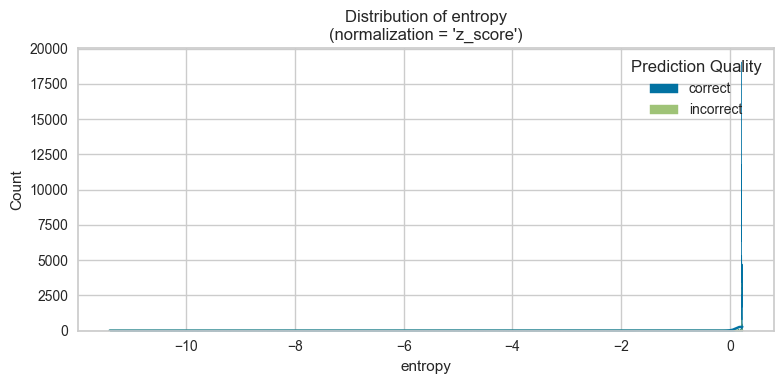

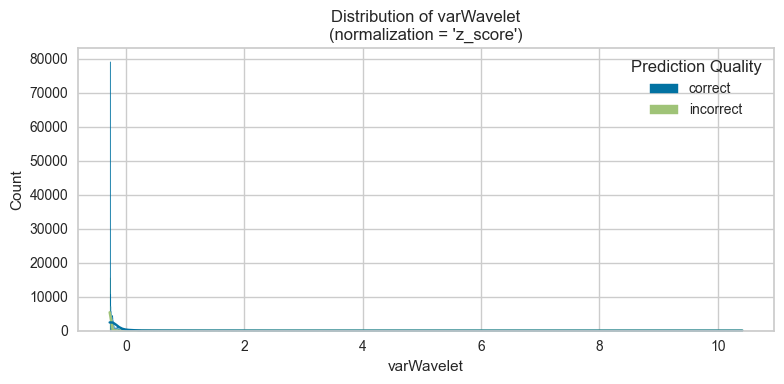

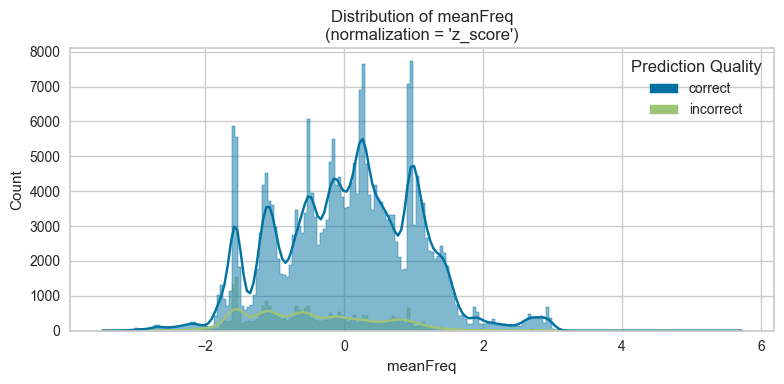

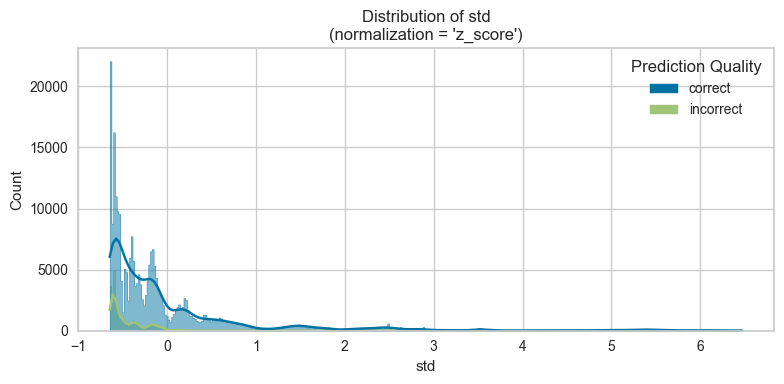

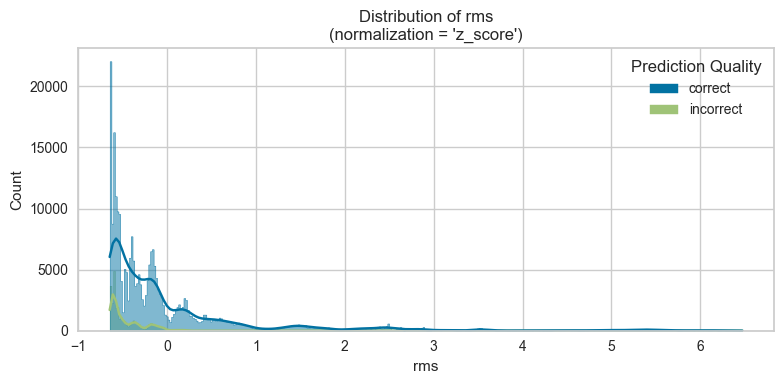

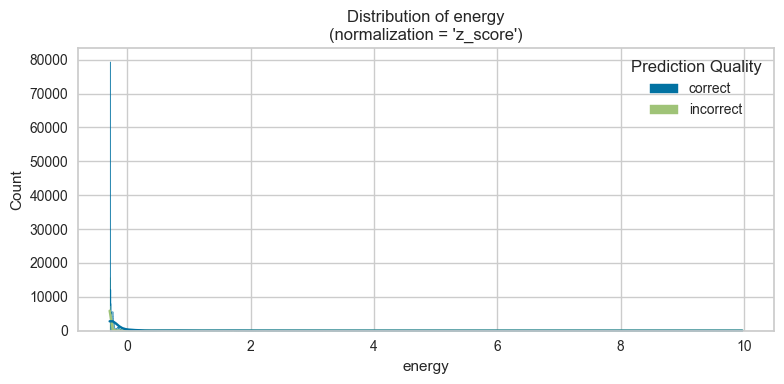

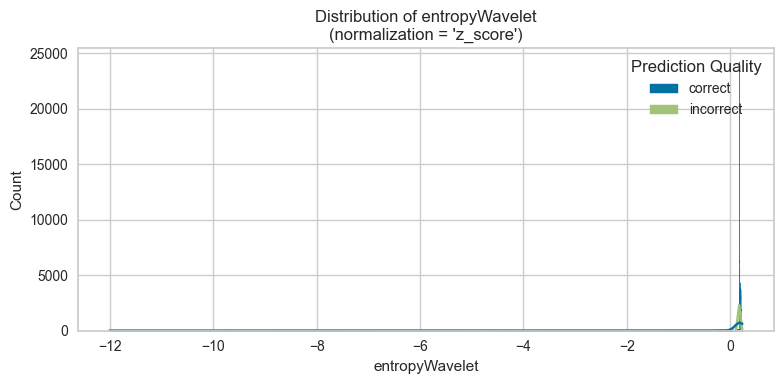

In [36]:
plotPredictionHistograms(predictions_lightgbm, normalization_method)

## Random Forest Classifier

In [37]:
bestParamsRF = {
    'bootstrap':True, 
    'ccp_alpha':0.0, 
    'class_weight':None,
    'criterion':'gini', 
    'max_depth':None, 
    'max_features':'sqrt',
    'max_leaf_nodes':None, 
    'max_samples':None,
    'min_impurity_decrease':0.0, 
    'min_samples_leaf':1,
    'min_samples_split':2, 
    'min_weight_fraction_leaf':0.0,
    'monotonic_cst':None, 
    'n_estimators':100, 
    'n_jobs':-1,
    'oob_score':False, 
    'random_state':1768, 
    'verbose':False,
    'warm_start':False
}

In [38]:
rf = create_model('rf', **bestParamsRF)

Traceback (most recent call last):
  File "C:\Users\ge35yay\.conda\envs\venv_masterarbeit_RMT\Lib\site-packages\mlflow\store\tracking\file_store.py", line 317, in search_experiments
    exp = self._get_experiment(exp_id, view_type)
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\ge35yay\.conda\envs\venv_masterarbeit_RMT\Lib\site-packages\mlflow\store\tracking\file_store.py", line 410, in _get_experiment
    meta = FileStore._read_yaml(experiment_dir, FileStore.META_DATA_FILE_NAME)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\ge35yay\.conda\envs\venv_masterarbeit_RMT\Lib\site-packages\mlflow\store\tracking\file_store.py", line 1341, in _read_yaml
    return _read_helper(root, file_name, attempts_remaining=retries)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\ge35yay\.conda\envs\venv_masterarbeit_RMT\Lib\site-packages\mlflow\store\tracking\file_store.py", line 1334, in _read_hel

In [39]:
evaluate_model(rf)

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Pipeline Plot', 'pipelin…

In [40]:
rf_top_features = get_feature_importance_df(rf, features_df_training_normalized)
rf_top_features

,Features,importance
0,meanWavelet,0.233514
1,medianFreq,0.103953
2,spectral_entropy,0.099822
3,rms,0.089682
4,meanFreq,0.073598
5,std,0.070901
6,spectral_skewness,0.069406
7,varWavelet,0.055737
8,crest,0.051662
9,entropyWavelet,0.049641


In [41]:
add_top_features(rf_top_features, top_n=3)

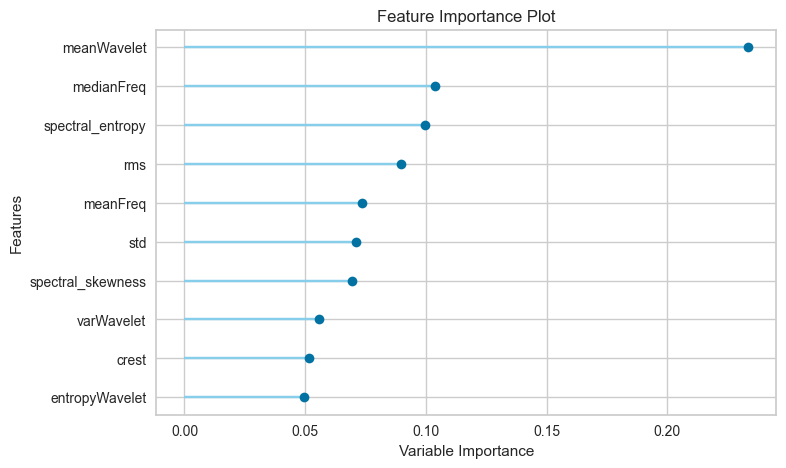

In [42]:
plot_model(rf, plot='feature')

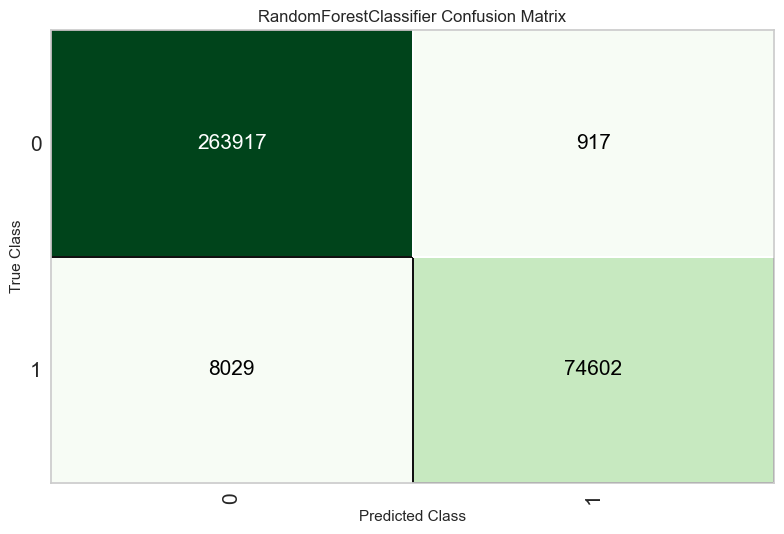

In [43]:
plot_model(rf, plot='confusion_matrix')

In [44]:
predictions_rf = predict_model(rf, data = features_df_testing_normalized)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,Balance Acc,Hamming Loss,Jaccard Score,Log Loss
0,Random Forest Classifier,0.9740,0.9948,0.9740,0.9744,0.9736,0.9260,0.9277,0.9491,0.0260,0.8918,0.0718


In [45]:
get_incorrect_predictions(predictions_rf)

,medianFreq,meanWavelet,spectral_entropy,spectral_skewness,entropySpectrogram,crest,entropy,varWavelet,meanFreq,std,rms,energy,entropyWavelet,Label,prediction_label,prediction_score
1147751,-0.970482,-0.330750,-0.360333,-0.395950,-0.166373,-0.301183,0.216681,-0.253985,-1.113300,-0.331838,-0.331839,-0.266948,0.188616,healthy,damaged,0.80
1178305,-0.291280,-0.072828,-0.228069,-1.048459,-0.165836,-0.094098,0.219520,-0.219283,-0.470118,-0.104747,-0.104748,-0.227698,0.203438,healthy,damaged,0.88
1142784,-0.974246,-0.338377,-0.360502,-0.727183,-0.166360,-0.194174,0.216235,-0.254851,-1.080116,-0.339043,-0.339041,-0.267851,0.188011,healthy,damaged,0.77
1154176,-1.043736,-0.424692,-0.387257,-0.135362,-0.166335,0.181833,0.214420,-0.257259,-1.565271,-0.371191,-0.371192,-0.271625,0.183395,healthy,damaged,0.76
1145949,-1.044505,-0.518867,-0.420001,-0.261687,-0.166474,-0.439252,0.210645,-0.267270,-1.532193,-0.481349,-0.481349,-0.281383,0.178047,healthy,damaged,0.99
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1165549,-0.829916,-0.076391,-0.220515,-0.156592,-0.165533,0.061906,0.217447,-0.222381,-0.522771,-0.106837,-0.106838,-0.228155,0.202280,healthy,damaged,0.59
1440200,-1.056862,-0.390536,-0.359200,0.618470,-0.165889,-0.187862,0.216028,-0.246179,-1.572637,-0.292864,-0.292865,-0.261697,0.185166,damaged,healthy,0.67
1188156,-1.031600,-0.417336,-0.380923,-0.036185,-0.166366,-0.459909,0.215210,-0.257421,-1.520408,-0.371237,-0.371238,-0.271630,0.184046,healthy,damaged,0.59
1162420,1.069145,-0.126051,-0.220889,0.492526,-0.165863,0.024374,0.220087,-0.219653,1.298172,-0.086851,-0.086851,-0.223717,0.199819,healthy,damaged,0.62


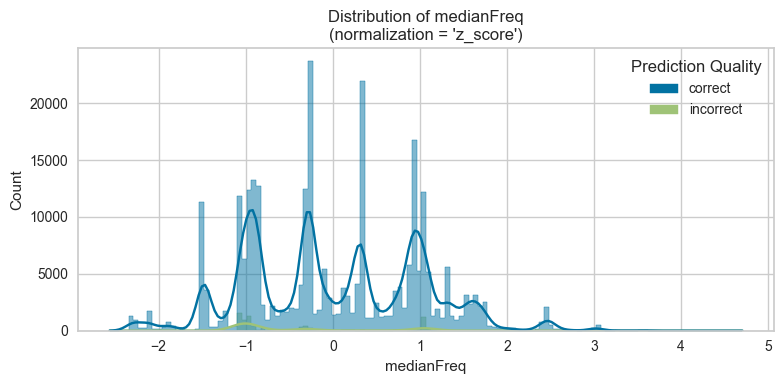

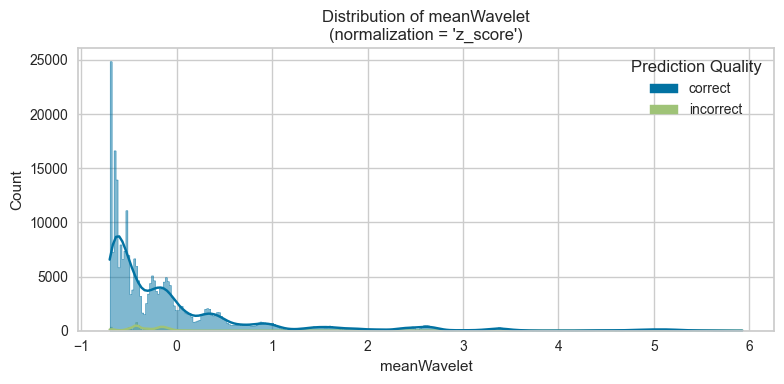

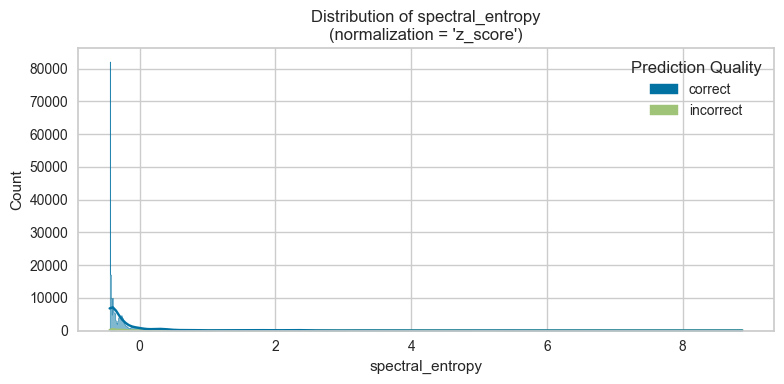

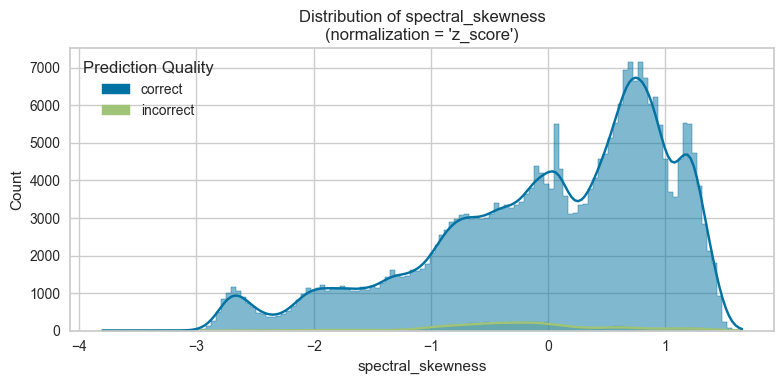

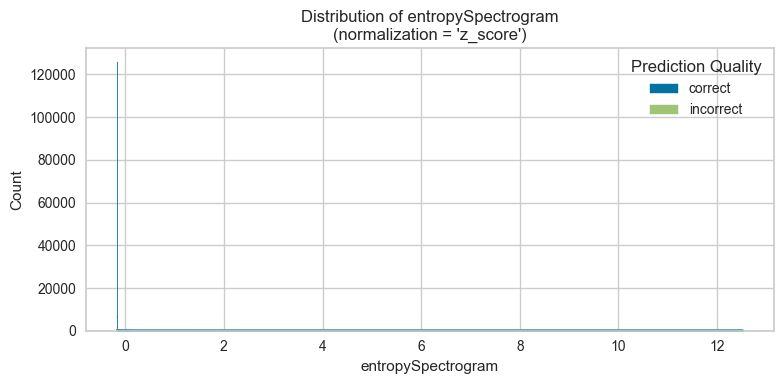

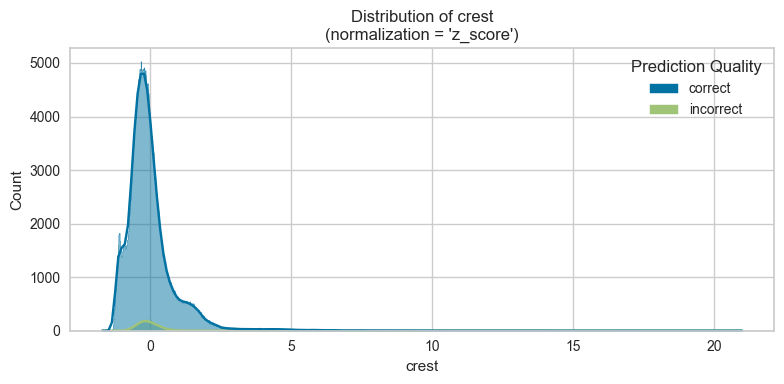

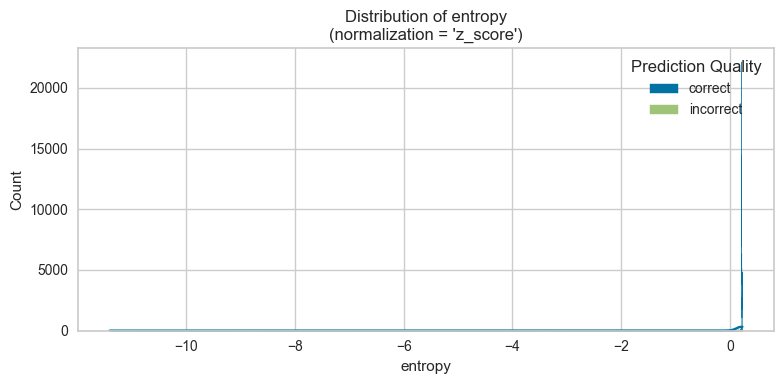

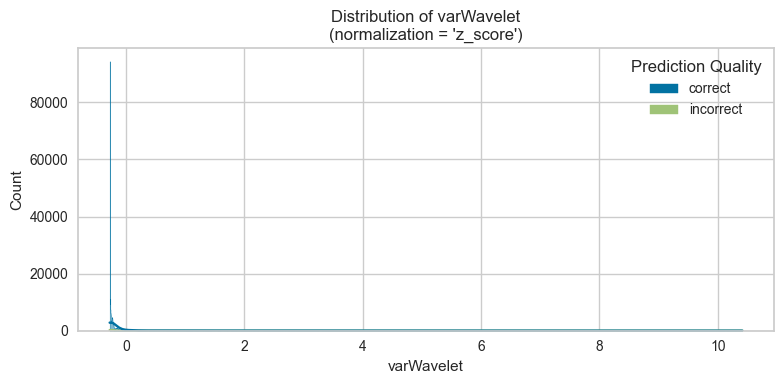

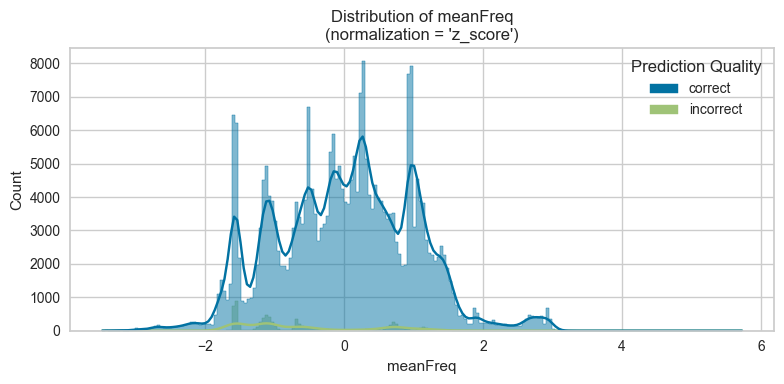

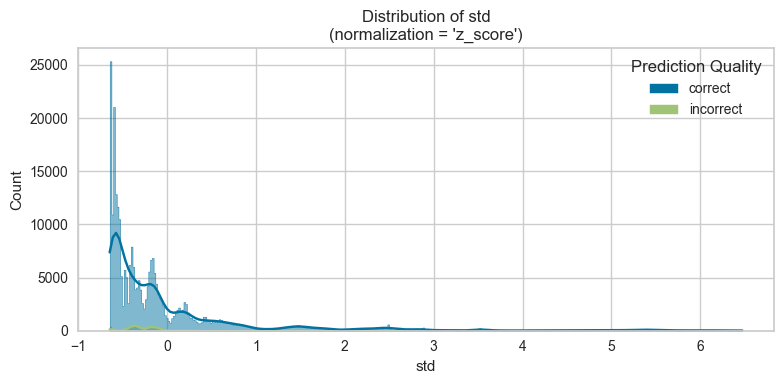

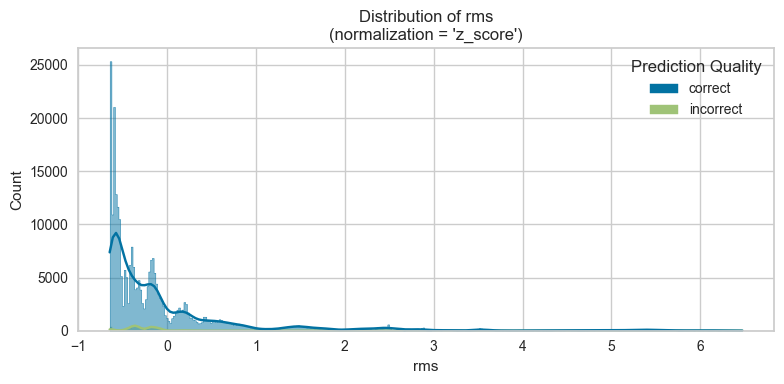

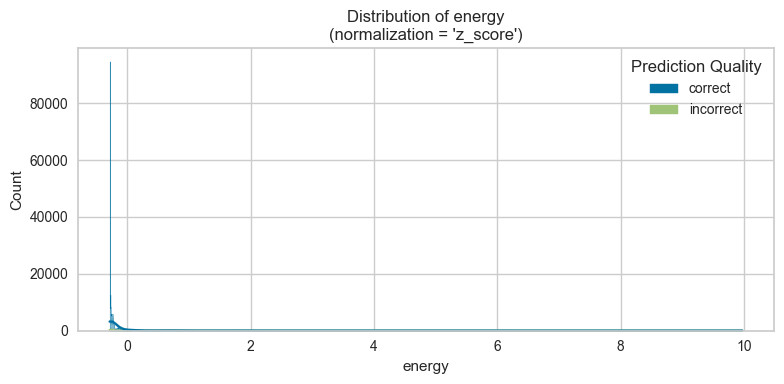

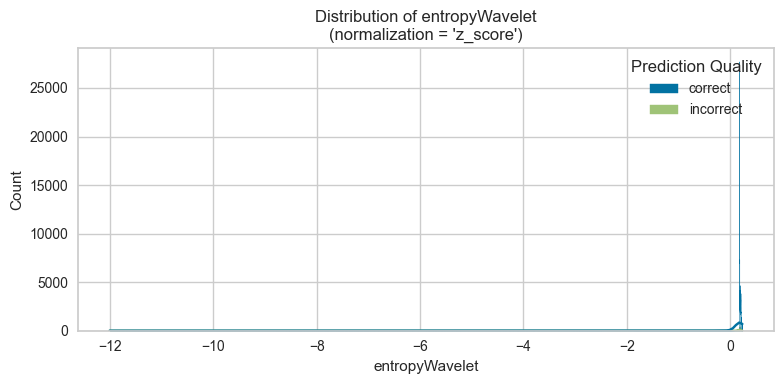

In [46]:
plotPredictionHistograms(predictions_rf, normalization_method)

## SVM

In [47]:
bestParamsSVM = {
    'alpha':1.983570694577895e-06, 
    'average':False, 
    'class_weight':None,
    'early_stopping':False, 
    'epsilon':0.1, 
    'eta0':0.050879465480455605,
    'fit_intercept':True, 
    'l1_ratio':0.3264919553269943,
    'learning_rate':'adaptive', 
    'loss':'hinge', 
    'max_iter':1000,
    'n_iter_no_change':5, 
    'n_jobs':-1, 
    'penalty':'l2', 
    'power_t':0.5,
    'random_state':1768, 
    'shuffle':True, 
    'tol':0.001,
    'validation_fraction':0.1, 
    'verbose':False, 
    'warm_start':False
}

In [48]:
svm = create_model('svm', **bestParamsSVM)

Traceback (most recent call last):
  File "C:\Users\ge35yay\.conda\envs\venv_masterarbeit_RMT\Lib\site-packages\mlflow\store\tracking\file_store.py", line 317, in search_experiments
    exp = self._get_experiment(exp_id, view_type)
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\ge35yay\.conda\envs\venv_masterarbeit_RMT\Lib\site-packages\mlflow\store\tracking\file_store.py", line 410, in _get_experiment
    meta = FileStore._read_yaml(experiment_dir, FileStore.META_DATA_FILE_NAME)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\ge35yay\.conda\envs\venv_masterarbeit_RMT\Lib\site-packages\mlflow\store\tracking\file_store.py", line 1341, in _read_yaml
    return _read_helper(root, file_name, attempts_remaining=retries)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\ge35yay\.conda\envs\venv_masterarbeit_RMT\Lib\site-packages\mlflow\store\tracking\file_store.py", line 1334, in _read_hel

In [49]:
evaluate_model(svm)

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Pipeline Plot', 'pipelin…

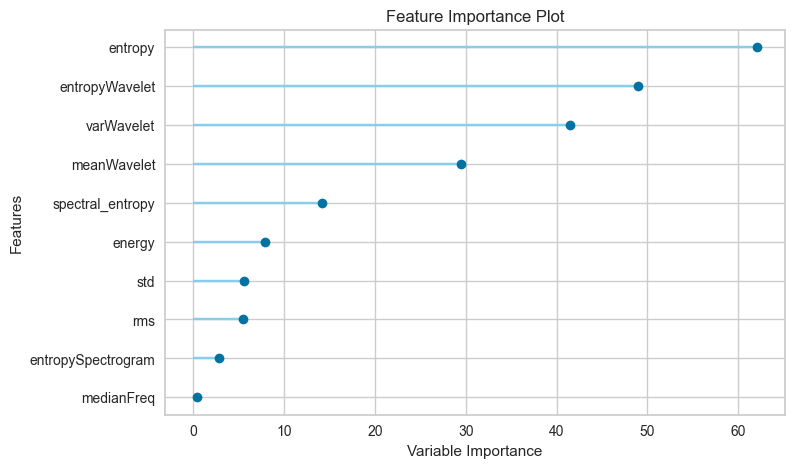

In [50]:
plot_model(svm, plot='feature')

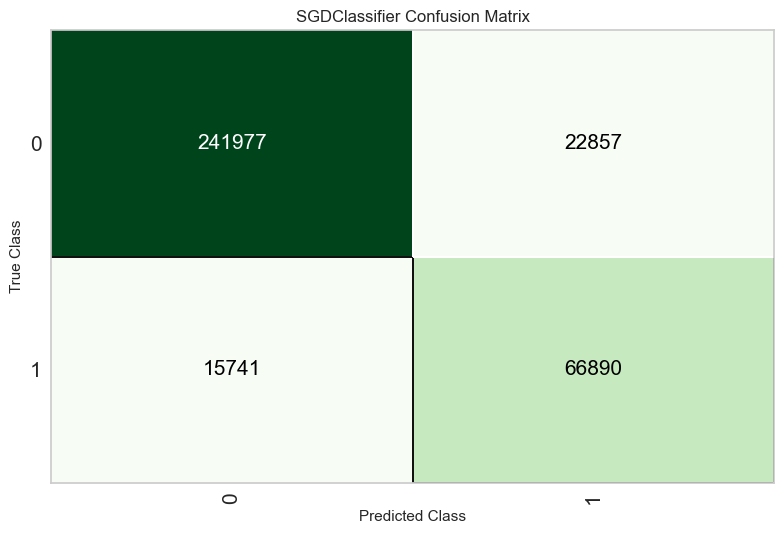

In [51]:
plot_model(svm, plot='confusion_matrix')

In [52]:
predictions_svm = predict_model(svm, data=features_df_testing_normalized)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,Balance Acc,Hamming Loss,Jaccard Score,Log Loss
0,SVM - Linear Kernel,0.8892,0,0.8892,0.8931,0.8908,0.7030,0.7040,0.8617,0.1108,0.6346,0


In [53]:
get_incorrect_predictions(predictions_svm)

,medianFreq,meanWavelet,spectral_entropy,spectral_skewness,entropySpectrogram,crest,entropy,varWavelet,meanFreq,std,rms,energy,entropyWavelet,Label,prediction_label
1147751,-0.970482,-0.330750,-0.360333,-0.395950,-0.166373,-0.301183,0.216681,-0.253985,-1.113300,-0.331838,-0.331839,-0.266948,0.188616,healthy,damaged
302654,-0.892717,-0.615573,-0.438652,0.613841,-0.166493,-0.344809,0.207165,-0.271789,-0.599916,-0.581299,-0.581300,-0.285984,0.173401,damaged,healthy
130547,-0.113441,-0.607815,-0.436884,1.061889,-0.166492,-0.735765,0.207618,-0.271480,0.313728,-0.567295,-0.567296,-0.285583,0.173793,damaged,healthy
553381,-1.479405,-0.649226,-0.441319,0.993163,-0.166493,2.169790,0.206410,-0.272281,-1.364569,-0.609234,-0.609232,-0.286546,0.172406,healthy,damaged
1152823,1.056479,-0.116243,-0.251942,0.454566,-0.165322,-0.462923,0.221102,-0.214387,0.706168,-0.100900,-0.100899,-0.226853,0.199649,healthy,damaged
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
130934,-0.113847,-0.604378,-0.437046,1.161266,-0.166492,-0.560637,0.207692,-0.271423,0.272252,-0.565477,-0.565477,-0.285525,0.173899,damaged,healthy
407068,-1.483203,-0.628156,-0.440377,0.639420,-0.166493,-0.530443,0.206694,-0.272174,-1.437868,-0.598481,-0.598482,-0.286367,0.172787,damaged,healthy
1168460,-1.065907,-0.440726,-0.386021,0.018872,-0.166299,-0.046978,0.214402,-0.257176,-1.589562,-0.373010,-0.373011,-0.271826,0.182755,healthy,damaged
1162420,1.069145,-0.126051,-0.220889,0.492526,-0.165863,0.024374,0.220087,-0.219653,1.298172,-0.086851,-0.086851,-0.223717,0.199819,healthy,damaged


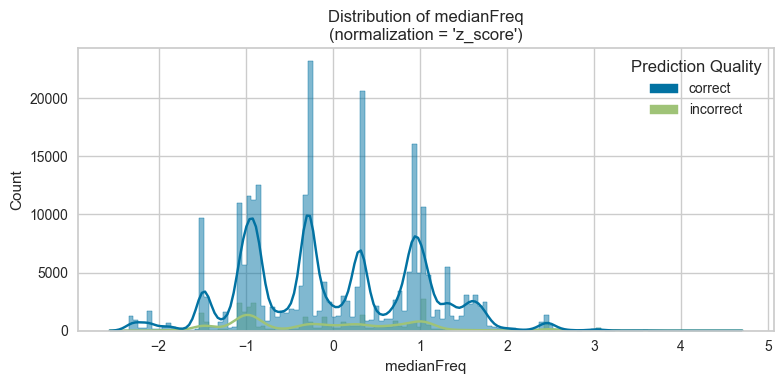

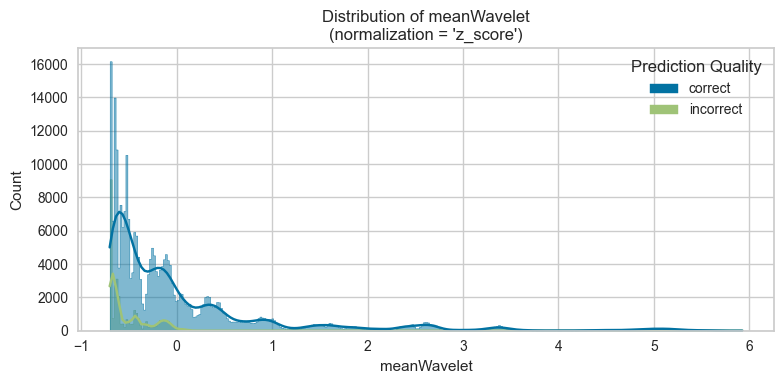

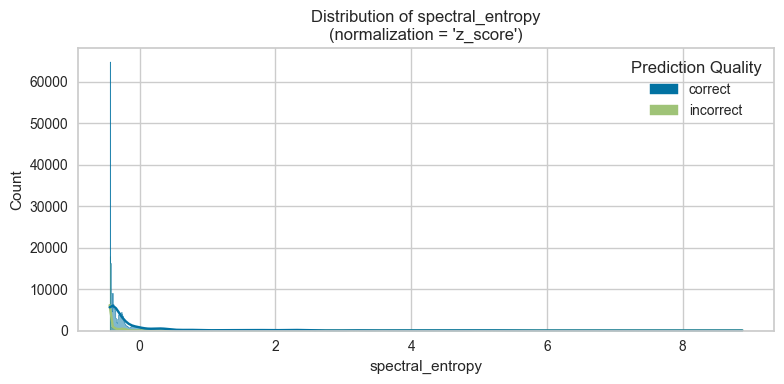

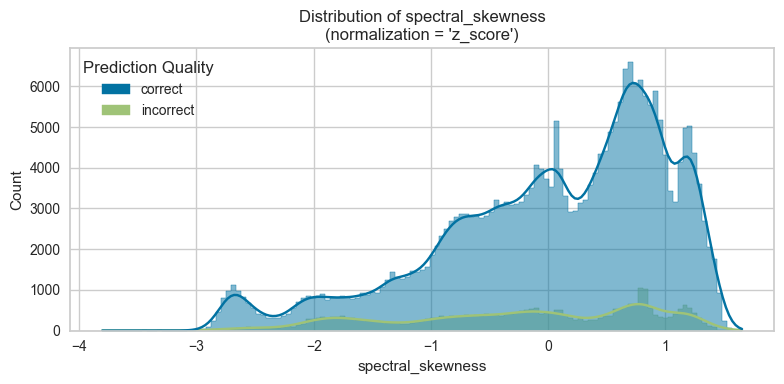

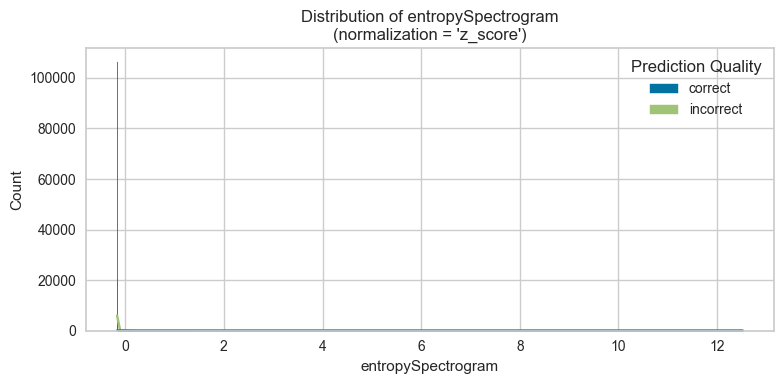

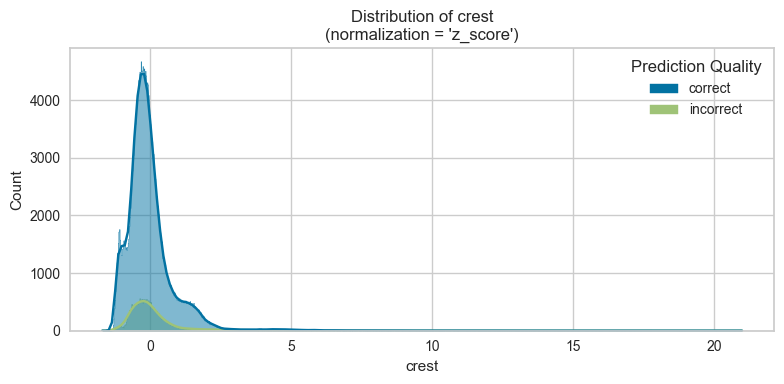

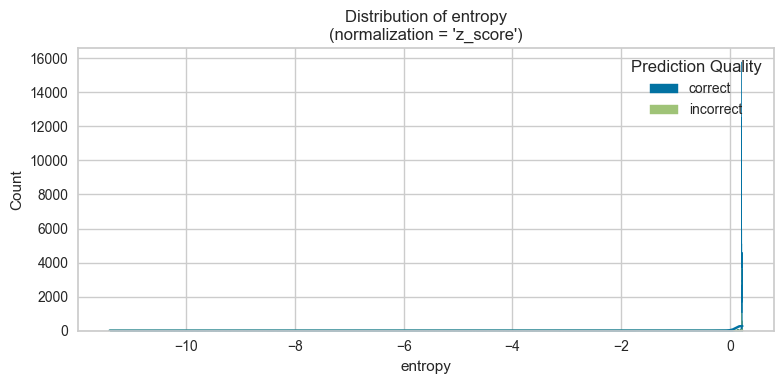

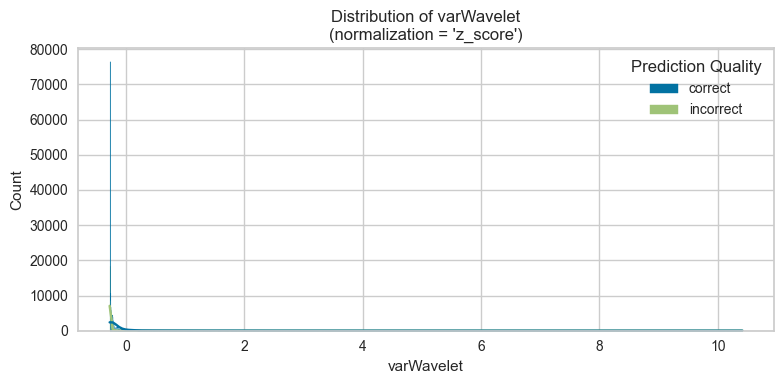

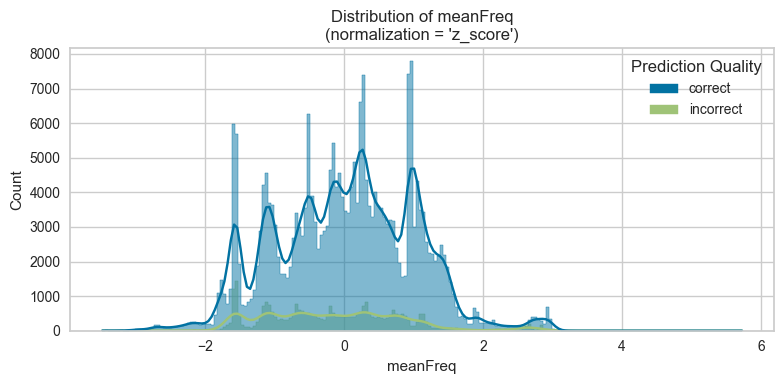

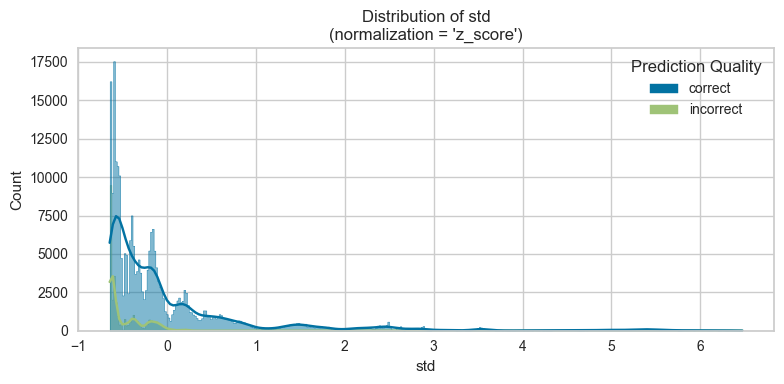

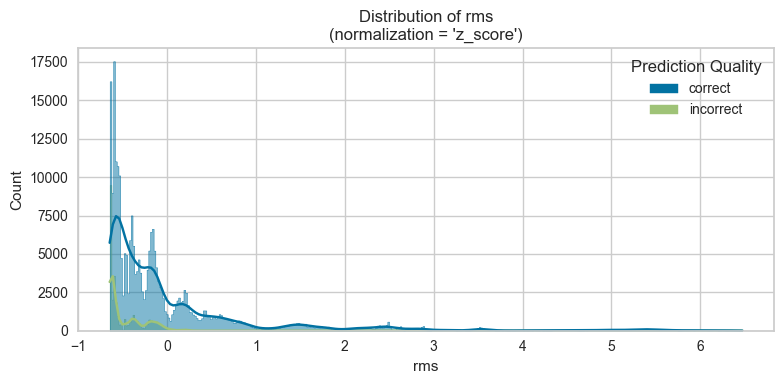

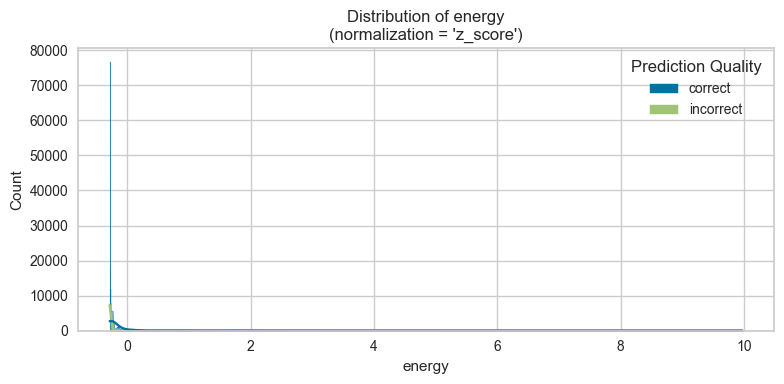

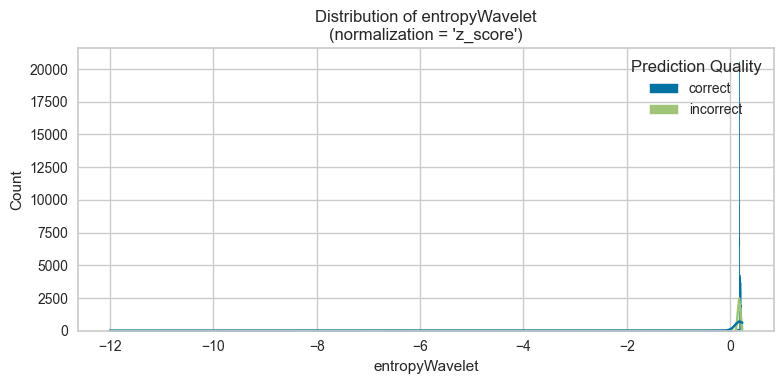

In [54]:
plotPredictionHistograms(predictions_svm, normalization_method)

# Experiment Setup (DL)

## Configure Data

In [55]:
train, test = train_test_split(normalized_df, test_size=0.2, random_state=42)
train, val = train_test_split(train, test_size=0.2, random_state=42)
print(f"Train Shape: {train.shape} | Val Shape: {val.shape} | Test Shape: {test.shape}")

Train Shape: (926572, 14) | Val Shape: (231644, 14) | Test Shape: (289555, 14)


In [56]:
target = "Label"
num_labels = normalized_df['Label'].nunique()

categorical_cols = [
    col
    for col in features_df_training_normalized.select_dtypes(include=["object","category"]).columns
    if col != target
]

continuous_cols = features_df_training_normalized.select_dtypes(include=["number"]).columns.tolist()

In [57]:
print("Target:", target)
print("Categorical inputs:", categorical_cols)  
print("Continuous inputs:", continuous_cols)    

Target: Label
Categorical inputs: []
Continuous inputs: ['medianFreq', 'meanWavelet', 'spectral_entropy', 'spectral_skewness', 'entropySpectrogram', 'crest', 'entropy', 'varWavelet', 'meanFreq', 'std', 'rms', 'energy', 'entropyWavelet']


In [58]:
data_config = DataConfig(
    target=[target],
    continuous_cols=continuous_cols,
    categorical_cols=categorical_cols,
)

In [59]:
available_gpu=1 if torch.cuda.is_available() else 0
print(f"Available GPU: {'Yes' if available_gpu else 'No'}")

Available GPU: Yes


In [60]:
trainer_config = TrainerConfig(
    auto_lr_find=False,
    max_epochs=10,
    accelerator='gpu' if torch.cuda.is_available() else 'cpu',
    batch_size=256,
)

optimizer_config = OptimizerConfig()

experiment_config = ExperimentConfig(
        project_name=experiment_name,
        run_name=f"{experiment_name}_run",
        log_target="tensorboard",
    )

In [61]:
tabnet_config = TabNetModelConfig(
        task="classification",
        n_d=33,
        n_a=46,
        n_steps=3,
        gamma=1.2864230491528987,
        embedding_dropout=0.1825276618254278,
        learning_rate=0.00468046516266798,
        metrics=[
            "accuracy", 
            "auroc",
            "recall",
            "precision",
            "f1_score",
            "cohen_kappa",
            "matthews_corrcoef",
            "hamming_distance",
            "jaccard_index",
        ],
        metrics_prob_input=[
            False,  #acc
            True,   # auroc
            False,  # recall
            False,  # precision
            False,  # f1_score
            False,  # cohen_kappa
            False,  # matthews_corrcoef
            False,  # hamming_distance
            False,  # jaccard_index
        ],
        metrics_params=[
            {"average": "macro"},
            {"average": "macro", "num_classes": normalized_df['Label'].nunique()},  # auroc
            {"average": "macro", "num_classes": normalized_df['Label'].nunique()},  # recall
            {"average": "macro", "num_classes": normalized_df['Label'].nunique()},  # precision
            {"average": "macro", "num_classes": normalized_df['Label'].nunique()},  # f1_score
            {"num_classes": normalized_df['Label'].nunique()},                      # cohen_kappa
            {},                                      # matthews_corrcoef
            {},                                      # hamming_distance
            {"average": "macro", "num_classes": normalized_df['Label'].nunique()},  # jaccard_index
        ]
    )

In [62]:
tabnet_model = TabularModel(
        data_config=data_config,
        model_config=tabnet_config,
        optimizer_config=optimizer_config,
        trainer_config=trainer_config,
        verbose=True
    )

2025-10-07 21:56:47,724 - {pytorch_tabular.tabular_model:146} - INFO - Experiment Tracking is turned off

In [63]:
tabnet_model.fit(train=train, validation=val)

Seed set to 42


2025-10-07 21:56:47,783 - {pytorch_tabular.tabular_model:548} - INFO - Preparing the DataLoaders

2025-10-07 21:56:47,921 - {pytorch_tabular.tabular_datamodule:522} - INFO - Setting up the datamodule for          
classification task

2025-10-07 21:56:48,480 - {pytorch_tabular.tabular_model:599} - INFO - Preparing the Model: TabNetModel

2025-10-07 21:56:48,606 - {pytorch_tabular.tabular_model:342} - INFO - Preparing the Trainer

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


2025-10-07 21:56:48,647 - {pytorch_tabular.tabular_model:678} - INFO - Training Started

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


┏━━━┳━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┓
┃   ┃ Name             ┃ Type             ┃ Params ┃ Mode  ┃
┡━━━╇━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━┩
│ 0 │ _embedding_layer │ Identity         │      0 │ train │
│ 1 │ _backbone        │ TabNetBackbone   │  121 K │ train │
│ 2 │ _head            │ Identity         │      0 │ train │
│ 3 │ loss             │ CrossEntropyLoss │      0 │ train │
└───┴──────────────────┴──────────────────┴────────┴───────┘

Trainable params: 121 K                                                                                            
Non-trainable params: 0                                                                                            
Total params: 121 K                                                                                                
Total estimated model params size (MB): 0                                                                          
Modules in train mode: 107                                                                                         
Modules in eval mode: 0

Output()

2025-10-07 22:17:41,302 - {pytorch_tabular.tabular_model:689} - INFO - Training the model completed

2025-10-07 22:17:41,302 - {pytorch_tabular.tabular_model:1529} - INFO - Loading the best model

In [64]:
tabnet_pred_df = tabnet_model.predict(test)
tabnet_pred_df.head(10)
tabnet_result = tabnet_model.evaluate(test)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Output()

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       test_accuracy       │    0.9362228512763977     │
│        test_auroc         │    0.9746791124343872     │
│     test_cohen_kappa      │    0.8100304007530212     │
│       test_f1_score       │    0.9362228512763977     │
│   test_hamming_distance   │    0.06377717852592468    │
│    test_jaccard_index     │    0.8314070701599121     │
│         test_loss         │    0.16548296809196472    │
│        test_loss_0        │    0.16548296809196472    │
│  test_matthews_corrcoef   │    0.8187426328659058     │
│      test_precision       │    0.9362228512763977     │
│        test_recall        │    0.9362228512763977     │
└───────────────────────────┴───────────────────────────┘

## GANDALF

In [65]:
gandalf_config = GANDALFConfig(
        task="classification",
        gflu_stages=8,
        gflu_dropout=0.20621973444441227,
        gflu_feature_init_sparsity=0.5069371167197942,
        learnable_sparsity=False,
        embedding_dropout= 0.06647823724375934,
        batch_norm_continuous_input=False,
        learning_rate=2.6124262014312122e-05,
        metrics=[
            "accuracy", 
            "auroc",
            "recall",
            "precision",
            "f1_score",
            "cohen_kappa",
            "matthews_corrcoef",
            "hamming_distance",
            "jaccard_index",
        ],
        metrics_prob_input=[
            False,  #acc
            True,   # auroc
            False,  # recall
            False,  # precision
            False,  # f1_score
            False,  # cohen_kappa
            False,  # matthews_corrcoef
            False,  # hamming_distance
            False,  # jaccard_index
        ],
        metrics_params=[
            {"average": "macro"},
            {"average": "macro", "num_classes": normalized_df['Label'].nunique()},  # auroc
            {"average": "macro", "num_classes": normalized_df['Label'].nunique()},  # recall
            {"average": "macro", "num_classes": normalized_df['Label'].nunique()},  # precision
            {"average": "macro", "num_classes": normalized_df['Label'].nunique()},  # f1_score
            {"num_classes": normalized_df['Label'].nunique()},                      # cohen_kappa
            {},                                      # matthews_corrcoef
            {},                                      # hamming_distance
            {"average": "macro", "num_classes": normalized_df['Label'].nunique()},  # jaccard_index
        ]
    )

In [66]:
gandalf_model = TabularModel(
    data_config=data_config,
    model_config=gandalf_config,
    optimizer_config=optimizer_config,
    trainer_config=trainer_config,
    verbose=True
)

2025-10-07 22:19:04,199 - {pytorch_tabular.tabular_model:146} - INFO - Experiment Tracking is turned off

In [67]:
gandalf_model.fit(train=train, validation=val)

Seed set to 42


2025-10-07 22:19:04,244 - {pytorch_tabular.tabular_model:548} - INFO - Preparing the DataLoaders

2025-10-07 22:19:04,356 - {pytorch_tabular.tabular_datamodule:522} - INFO - Setting up the datamodule for          
classification task

2025-10-07 22:19:04,938 - {pytorch_tabular.tabular_model:599} - INFO - Preparing the Model: GANDALFModel

2025-10-07 22:19:05,033 - {pytorch_tabular.tabular_model:342} - INFO - Preparing the Trainer

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


2025-10-07 22:19:05,095 - {pytorch_tabular.tabular_model:678} - INFO - Training Started

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


┏━━━┳━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┓
┃   ┃ Name             ┃ Type             ┃ Params ┃ Mode  ┃
┡━━━╇━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━┩
│ 0 │ _backbone        │ GANDALFBackbone  │  8.5 K │ train │
│ 1 │ _embedding_layer │ Embedding1dLayer │      0 │ train │
│ 2 │ _head            │ Sequential       │     30 │ train │
│ 3 │ loss             │ CrossEntropyLoss │      0 │ train │
└───┴──────────────────┴──────────────────┴────────┴───────┘

Trainable params: 8.6 K                                                                                            
Non-trainable params: 8                                                                                            
Total params: 8.6 K                                                                                                
Total estimated model params size (MB): 0                                                                          
Modules in train mode: 30                                                                                          
Modules in eval mode: 0

Output()

`Trainer.fit` stopped: `max_epochs=10` reached.


2025-10-07 23:02:42,741 - {pytorch_tabular.tabular_model:689} - INFO - Training the model completed

2025-10-07 23:02:42,741 - {pytorch_tabular.tabular_model:1529} - INFO - Loading the best model

In [68]:
gandalf_pred_df = gandalf_model.predict(test)
gandalf_pred_df.head(10)

,Label_damaged_probability,Label_healthy_probability,Label_prediction
964828,0.999454,0.000546,damaged
1096014,0.918509,0.081491,damaged
1147751,0.885545,0.114455,damaged
302654,0.694574,0.305426,damaged
130547,0.401137,0.598863,healthy
1366489,0.823393,0.176607,damaged
968670,0.992548,0.007452,damaged
1076725,0.961006,0.038994,damaged
553381,0.032464,0.967536,healthy
1352409,0.895802,0.104198,damaged


In [69]:
gandalf_result = gandalf_model.evaluate(test)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Output()

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       test_accuracy       │    0.8871751427650452     │
│        test_auroc         │    0.9130764007568359     │
│     test_cohen_kappa      │    0.6526345014572144     │
│       test_f1_score       │    0.8871751427650452     │
│   test_hamming_distance   │    0.11282484978437424    │
│    test_jaccard_index     │    0.7167463302612305     │
│         test_loss         │    0.31070154905319214    │
│        test_loss_0        │    0.31070154905319214    │
│  test_matthews_corrcoef   │    0.6687107682228088     │
│      test_precision       │    0.8871751427650452     │
│        test_recall        │    0.8871751427650452     │
└───────────────────────────┴───────────────────────────┘

In [70]:
gandalf_top_features = gandalf_model.feature_importance().sort_values("importance", ascending=False)
gandalf_top_features

,Features,importance
1,meanWavelet,1.323043
0,medianFreq,1.153420
3,spectral_skewness,0.862925
5,crest,0.661856
11,energy,0.655861
8,meanFreq,0.556043
6,entropy,0.497117
12,entropyWavelet,0.487330
2,spectral_entropy,0.425478
9,std,0.382371


In [71]:
add_top_features(gandalf_top_features, top_n=3)

In [ ]:
plot_feature_importance()